In [12]:
import numpy as np
import random
import pathlib
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Softmax
from sklearn.model_selection import train_test_split
from keras import callbacks
from imblearn.combine import SMOTETomek
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [13]:
file_path = 'Dataset'
data_dir = pathlib.Path(file_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Mild_Demented' 'Moderate_Demented' 'Non_Demented' 'Very_Mild_Demented']


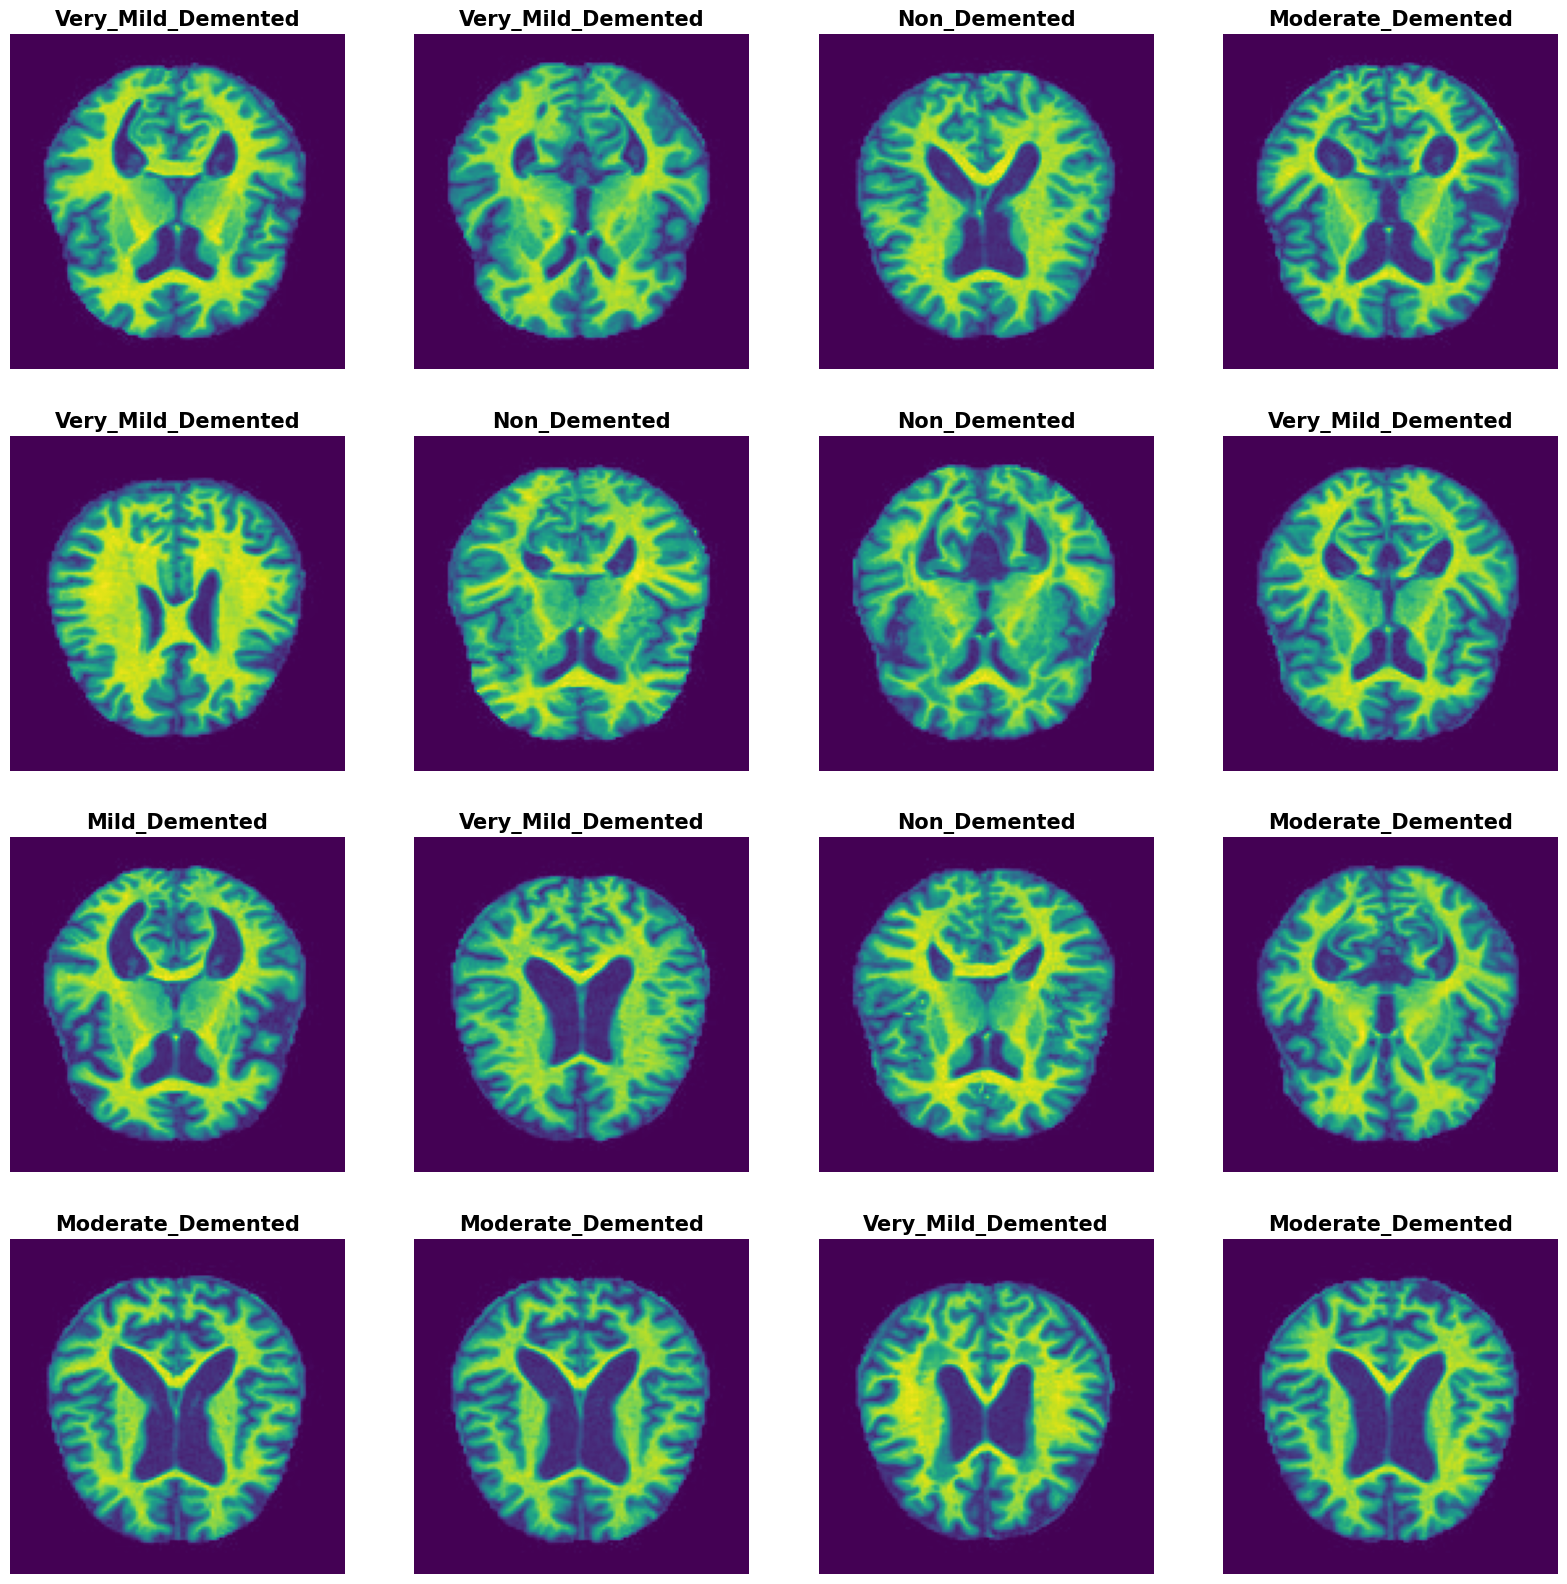

In [14]:
plt.figure(figsize=(20, 20)) 
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    random_class = random.randint(0, 3)
    folder_path = file_path + '/' + class_names[random_class]
    random_image_path = folder_path + '/' + (random.sample(os.listdir(folder_path), 1)[0])
    image = plt.imread(random_image_path)
    plt.axis('off')
    plt.title(class_names[random_class], fontsize = 15, fontweight = 'bold')
    plt.imshow(image)

In [15]:
X, y = [], []

## Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0)

#   Load images by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(file_path, target_size=(176, 208),batch_size=6400, shuffle=True)

### Seperate Dataset from  Data Genrator
X, y = train_dataset.next()

Found 6400 images belonging to 4 classes.


In [16]:
#   reshaping the images to 1D
X = X.reshape(-1, 176 * 208 * 3)

#   Oversampling method to remove imbalance class problem
X, y = SMOTETomek().fit_resample(X, y)

#   reshape images to images size of 208, 176, 3
X = X.reshape(-1, 176, 208, 3)

samples_after = len(X)
print("Number of samples after SMOTETomek :\t", sorted(Counter(np.argmax(y, axis=1)).items()))

Number of samples after SMOTETomek :	 [(0, 3200), (1, 3200), (2, 3200), (3, 3200)]


In [17]:
#   20% split to validation and 80% split to train set
X_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.2)

#   20% split to test from 80% of train and 60% remains in train set
X_train, x_test, y_train, y_test = train_test_split(X_train,y_train, test_size = 0.2)



In [18]:
from keras.initializers import GlorotUniformV2
init = GlorotUniformV2

model = Sequential()

model.add(Input(shape=(176, 208, 3)))

model.add(Convolution2D(16, 5, kernel_initializer=init))
model.add(ReLU())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Convolution2D(32, 5, kernel_initializer=init))
model.add(ReLU())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Convolution2D(64, 5, kernel_initializer=init))
model.add(ReLU())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Convolution2D(128, 5, kernel_initializer=init))
model.add(ReLU())
model.add(AveragePooling2D(pool_size=(2,2)))


model.add(Dropout(0.01))

model.add(Flatten())

model.add(Dense(256, kernel_initializer=init))
model.add(ReLU())
model.add(Dropout(0.03))

model.add(Dense(4, kernel_initializer=init))
model.add(Softmax())

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 172, 204, 16)      1216      
                                                                 
 re_lu (ReLU)                (None, 172, 204, 16)      0         
                                                                 
 average_pooling2d (AverageP  (None, 86, 102, 16)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 98, 32)        12832     
                                                                 
 re_lu_1 (ReLU)              (None, 82, 98, 32)        0         
                                                                 
 average_pooling2d_1 (Averag  (None, 41, 49, 32)       0         
 ePooling2D)                                            

In [19]:
### Model Compilation
model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=4),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") ])


In [20]:
# callbacks used in model to perform well
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2)

CALLBACKS = [rop_callback]

In [21]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 8

history = model.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 20,
batch_size=batch_size,
callbacks = CALLBACKS
)

Epoch 1/20
1024/1024 [==============================] - 341s 330ms/step - loss: 1.1987 - acc: 0.4335 - auc: 0.7105 - f1_score: 0.4294 - precision: 0.6925 - recall: 0.1625 - val_loss: 0.7913 - val_acc: 0.6187 - val_auc: 0.8821 - val_f1_score: 0.6084 - val_precision: 0.7425 - val_recall: 0.4956 - lr: 0.0100
Epoch 2/20
1024/1024 [==============================] - 307s 300ms/step - loss: 0.7208 - acc: 0.6533 - auc: 0.9001 - f1_score: 0.6491 - precision: 0.7571 - recall: 0.5349 - val_loss: 0.6178 - val_acc: 0.7144 - val_auc: 0.9300 - val_f1_score: 0.6888 - val_precision: 0.7960 - val_recall: 0.6021 - lr: 0.0100
Epoch 3/20
1024/1024 [==============================] - 315s 308ms/step - loss: 0.5943 - acc: 0.7340 - auc: 0.9337 - f1_score: 0.7327 - precision: 0.7876 - recall: 0.6520 - val_loss: 0.5677 - val_acc: 0.7451 - val_auc: 0.9414 - val_f1_score: 0.7441 - val_precision: 0.8167 - val_recall: 0.6460 - lr: 0.0100
Epoch 4/20
1024/1024 [==============================] - 334s 326ms/step - loss:

[]

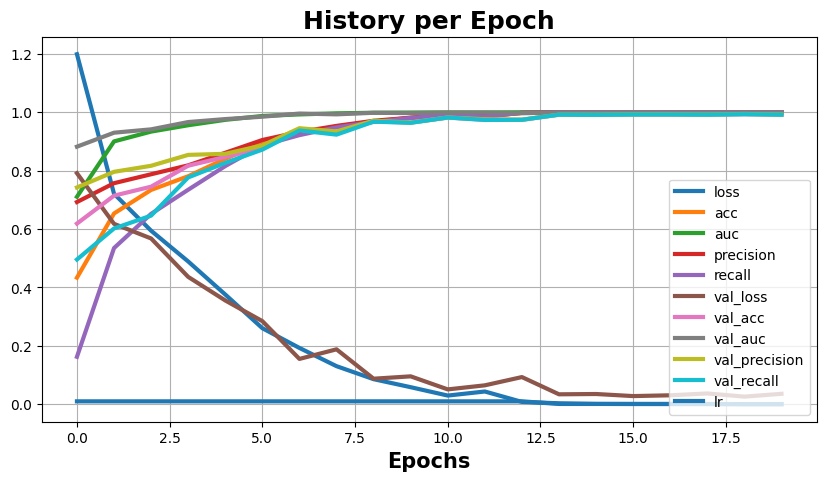

In [23]:
df = pd.DataFrame(history.history)
ax = df.plot(figsize=(10,5), lw=3, grid='on')
ax.set_title('History per Epoch', fontsize=18, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax.plot()

In [24]:
pred_labels = model.predict(x_test, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(y_test, pred_labels, target_names=class_names))


64/64 [==============================] - 23s 335ms/step
                   precision    recall  f1-score   support

    Mild-Demented       1.00      1.00      1.00       541
Moderate-Demented       1.00      1.00      1.00       525
     Non-Demented       1.00      0.97      0.98       500
VeryMild-Demented       0.98      1.00      0.99       482

        micro avg       0.99      0.99      0.99      2048
        macro avg       0.99      0.99      0.99      2048
     weighted avg       0.99      0.99      0.99      2048
      samples avg       0.99      0.99      0.99      2048



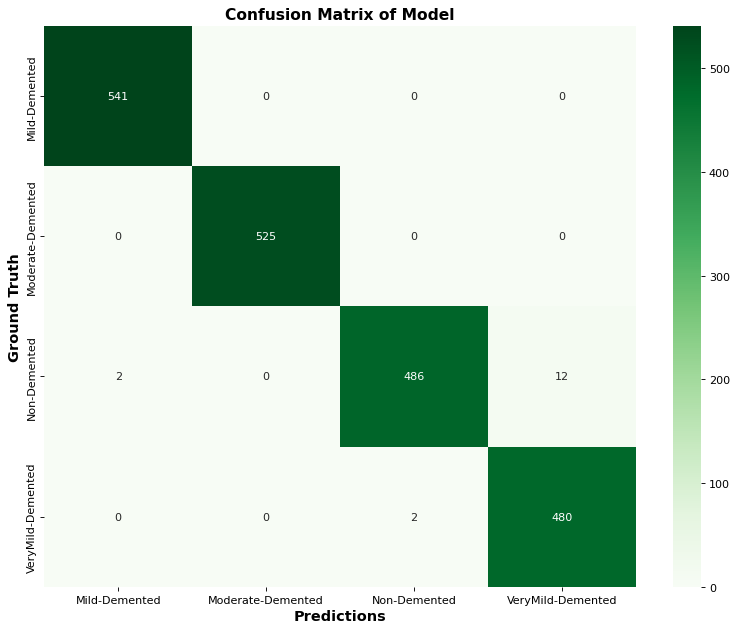

In [25]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= class_names, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

In [26]:
#    To save the model in the current directory
model.save(".\\model.h5")